In [1]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html

from io_data import loadSpatialDataset
from analyze import calcUmap, plotUmap
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import random
from tqdm import tqdm

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

In [3]:
adata = loadSpatialDataset(single_gene_images_glob = "/media/gambino/students_workdir/nynke/blurry_model/ileum_data/mouse_ileum/coordinate_parsed/*.tif", adata_to_concat="blurry")

Loading images: 100%|██████████| 3514/3514 [02:36<00:00, 22.52image/s]


<class 'io_data.ImageDatasetWithDapis'>


100%|██████████| 7/7 [00:11<00:00,  1.69s/it]
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass 

In [4]:
adata

AnnData object with n_obs × n_vars = 224201 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'blur_interval', 'prop', 'prop_interval', 'corresponding_dapis', 'original_image_paths', 'binary_classified', 'classified', 'pattern_classified', 'cell-edge', 'extranuclear', 'intranuclear', 'pericellular', 'perinuclear', 'random', 'random_score', 'pattern_score', 'batch'
    obsm: 'latent'

### Split in train val test 

In [4]:
# Step 1: Get the indices of the observations
all_indices = adata.obs.index

# Step 2: Perform train-val-test split on indices. Total split is 80-10-10
train_indices, test_indices = skm.train_test_split(all_indices, test_size=0.1, random_state=seed)
train_indices, val_indices = skm.train_test_split(train_indices, test_size=1/9, random_state=seed)

# Step 3: Subset AnnData object using the obtained indices
adata_train = adata[train_indices, :] # 179360 x 15
adata_val = adata[val_indices, :]     # 22420  x 15
adata_test = adata[test_indices, :]   # 22421  x 15
# total adata object:                   224201 x 15

Max features for the random forest at first will be put to sqrt(15) ~3. Based on validation will see whether want to change that to 4. 
* `n_estimators`: number of trees
* `max_features`: size of random subset of features to consider when splitting a node. The lower: the greater reduction in variance, but the higher increase in bias. Empirical good default values: max_features=”sqrt” (according to [scikit-learn](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters))
    * Do parameter search [2,3,4,5], because sqrt(15)~3.87, so we choose 2,3,4,5 as values around that. 
* `max_leaf_nodes`: maximum number of leafs at the bottom of the tree. 
    * Included to reduce memory consumption, as the default settings for controlling the tree size will result in fully grown and unpruned trees.
* By default, bootstramp samples are used. When using bootstrap sampling, the generalization error can be estimated on the left out (or out-of-bag) samples. You can enable this with setting `oob_score=True`

In [6]:
# Create a random forest classifier.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=seed, max_features='sqrt', bootstrap=True, oob_score=True)
rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

RandomForestClassifier(oob_score=True, random_state=101)

In [32]:
#out of bag score during training
rf_classifier.oob_score_

0.9246989295272079

In [13]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV

In [8]:
adata_train_labels = adata_train.copy()
pattern_mapping = {'pattern': 1, 'random': 0}
adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

The code below did a GridSearchCV. However, because of the large gridsearch space, it was too time consuming and was stopped. Instead we will use halvingGridSearchCV

In [ ]:
latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]

base_forest = RandomForestClassifier(random_state=seed, bootstrap=True, oob_score=True, n_estimators=100)
param_grid = {'max_leaf_nodes':[6,10,14], 'max_features': [2,3,4,5]}

grid_search = GridSearchCV(base_forest, param_grid=param_grid, scoring='f1', verbose=1, error_score='raise')
grid_search.fit(latent,labels)
results = grid_search.cv_results_
print("results: " + results)
print("n_resources: " + grid_search.n_resources_)

the idea behind HalvingGridSearchCV is that you will do multiple iterations of cv to find the best parameter combinations. Initially everything is tested with few resources and an initialy selection is made. In each selection round fewer make it through and are tested with more resources. The candidates in the last round have consistently ranked at the topf candidates across all iterations. until the best is selected based on the most resources. 

In [16]:
latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]

base_forest = RandomForestClassifier(max_features='sqrt', random_state=rng, bootstrap=True, oob_score=True)
features = [2,3,4,5]
param_grid = {'max_leaf_nodes':[6,10,14,18], 'max_features': features}

grid_search = HalvingGridSearchCV(estimator=base_forest, param_grid=param_grid, min_resources=20, factor=2, resource="n_estimators", max_resources=320, scoring='f1', verbose=1, error_score='raise')
grid_search.fit(latent,labels)
print(grid_search.n_resources_)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 20
max_resources_: 320
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 16
n_resources: 20
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used

----------
iter: 1
n_candidates: 8
n_resources: 40
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 2
n_candidates: 4
n_resources: 80
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 160
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 4
n_candidates: 1
n_resources: 320
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[20, 40, 80, 160, 320]


In [21]:
grid_search.best_params_

{'max_features': 3, 'max_leaf_nodes': 18, 'n_estimators': 320}

Now that we have found the optimal parameters for `max_features` and `max_leaf_nodes`, we will look at which value should be chosen for the `n_estimators`

In [22]:
train_accuracy = []
val_accuracy = []
for count in tqdm(range(50, 501, 50)):
    # create random forest classifier and fit on training data
    rf_classifier = RandomForestClassifier(n_estimators=count, random_state=seed, max_features=3, max_leaf_nodes=18, bootstrap=True, oob_score=True)
    rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 
    
    #predict label
    train_pred = rf_classifier.predict(adata_train.obsm["latent"])
    val_pred = rf_classifier.predict(adata_val.obsm["latent"])

    # Obtain training and validation F1 score. 
    train_f1 = f1_score(adata_train.obs["random_or_pattern"], train_pred, pos_label='pattern')
    val_f1 = f1_score(adata_val.obs["random_or_pattern"], val_pred, pos_label='pattern')

    #append scores to lists
    train_accuracy.append(train_f1)
    val_accuracy.append(val_f1)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [09:43<00:00, 58.38s/it]


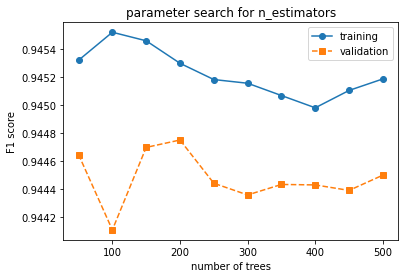

In [26]:
plt.figure()

x_values = range(50, 501, 50)

plt.plot(x_values, train_accuracy, label='training', linestyle='-', marker='o')
plt.plot(x_values, val_accuracy, label='validation', linestyle='--', marker='s')

# Add labels and legend
plt.title('parameter search for n_estimators')
plt.xlabel('number of trees')
plt.ylabel('F1 score')
plt.legend()
plt.show()

200 trees seems to give the best results

## Next step

run the random forest for optimal parameters and get F1 score.
select only the pattern ones, and then do random forest on the pattern labels. 
In the end wanna do a for loop to combine the combinations between the different ones. random forest + other stuff etc. 

In [ ]:
calcUmap(adata)
plotUmap(adata, "pattern", "./test_real_data_overlay.png", pattern_to_alpha = "spatial")

# Support Vector Machines

# Multinomial Logit Models